In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from mapie.regression import MapieRegressor

In [2]:
df_train = pd.read_csv('./bases/Train.csv')
# Base para concatenar predicciones y subir a Kaggle
df_test = pd.read_csv('./bases/Test.csv')

In [3]:
df_train[df_train['Item_Identifier'] == 'FDA15' ].head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
831,FDA15,9.3,Low Fat,0.016055,Dairy,250.2092,OUT045,2002,NaN,Tier 2,Supermarket Type1,5976.2208


# Analisis Descriptivo:

In [4]:
# df_train.describe()

In [5]:
# fig, axes = plt.subplots(2, 2,figsize=(15,10))
# sns.histplot(data=df_train,x='Item_Weight',ax=axes[0,0])
# sns.histplot(data=df_train,x='Item_Visibility',ax=axes[0,1])
# sns.histplot(data=df_train,x='Item_MRP',ax=axes[1,0])
# sns.histplot(data=df_train,x='Outlet_Establishment_Year',ax=axes[1,1])
# plt.show()

In [6]:
# axis=sns.pairplot(df_train)

In [7]:
# df_train.nunique()

In [8]:
# df_train.isna().sum(axis=0)/len(df_train)
# df_train.isna().sum(axis=0)

# Transformación de variables

In [9]:
# Transormando el tipo de dato OBJECT a Category
df_train['Item_Fat_Content'] = df_train.Item_Fat_Content.astype('category')
df_train['Item_Type'] = df_train.Item_Type.astype('category')
df_train['Outlet_Identifier'] = df_train.Outlet_Identifier.astype('category')
df_train['Outlet_Size'] = df_train.Outlet_Size.astype('category')
df_train['Outlet_Location_Type'] = df_train.Outlet_Location_Type.astype('category')
df_train['Outlet_Type'] = df_train.Outlet_Type.astype('category')
df_train['Outlet_Establishment_Year'] = df_train.Outlet_Establishment_Year.astype('category')
# se puede omitir este codigo abajo
df_test['Item_Fat_Content'] = df_test.Item_Fat_Content.astype('category')
df_test['Item_Type'] = df_test.Item_Type.astype('category')
df_test['Outlet_Identifier'] = df_test.Outlet_Identifier.astype('category')
df_test['Outlet_Size'] = df_test.Outlet_Size.astype('category')
df_test['Outlet_Location_Type'] = df_test.Outlet_Location_Type.astype('category')
df_test['Outlet_Type'] = df_test.Outlet_Type.astype('category')
df_test['Outlet_Establishment_Year'] = df_test.Outlet_Establishment_Year.astype('category')

In [10]:
# Se decide eliminar los N.A. de la variable categorica Outlet Size.
## Se podría imputar la moda, segun conveniencia
df_train.dropna(subset=['Outlet_Size'],inplace=True)
# Por alguna razón, la clase SimpleImputer de Sklearn NO sirve en mi pipeline
## Decido imputar la media a los NA de la variable Item_weight, teniendo en cuenta
### que sus medidas de tendencia central no se ven afectadas por outliers
df_train['Item_Weight'].fillna(df_train['Item_Weight'].mean(), inplace=True)
df_train.drop(['Item_Identifier'],axis=1,inplace=True)

df_test.dropna(subset=['Outlet_Size'],inplace=True)
df_test['Item_Weight'].fillna(df_test['Item_Weight'].mean(), inplace=True)
df_test.drop(['Item_Identifier'],axis=1,inplace=True)

# ## OTRA FORMA_: Utilizar la clase SimpleImputer()
# imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
# imputer.fit(df_train[['Item_Weight']])
# df_train['Item_Weight'] = imputer.transform(df_train[['Item_Weight']]).ravel()

## Corrección de clases: Estandarizando los valores de Item_Fat_Content 
item_fat = {'Low Fat':'low', 'Regular':'regular', 'LF':'low', 'reg':'regular','low fat':'low'}
df_train['Item_Fat_Content'] = df_train['Item_Fat_Content'].map(item_fat)
df_test['Item_Fat_Content'] = df_test['Item_Fat_Content'].map(item_fat)

In [11]:
vars_catg = ['Item_Fat_Content','Item_Type','Outlet_Identifier','Outlet_Establishment_Year','Outlet_Size',
             'Outlet_Location_Type','Outlet_Type']
var_num_null = ['Item_Weight']
vars_num = ['Item_Weight','Item_Visibility','Item_MRP']

# ## Otra forma de volver Dummys
# train = pd.get_dummies(df_train, columns=vars_catg)
# test = pd.get_dummies(df_test, columns=vars_catg)

X = df_train.drop(['Item_Outlet_Sales'],axis=1)
y = df_train['Item_Outlet_Sales'].agg(np.log1p)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [12]:
prepoc = ColumnTransformer([
            # No funciona el simple imputer, leí documentación al respecto sin éxito.
#         ('mean_imputer',SimpleImputer(strategy='mean',fill_value='missing'),var_num_null),
        ('dummy',OneHotEncoder(drop='first'),vars_catg),
        ('log',FunctionTransformer(np.log1p, validate=False),vars_num)
])


## Regresión Lineal

In [13]:
Model_lineal = Pipeline([('preprocesamiento',prepoc),
                       ('Regresión Lineal', LinearRegression())])

In [14]:
Model_lineal.fit(X_train,y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('dummy',
                                                  OneHotEncoder(drop='first'),
                                                  ['Item_Fat_Content',
                                                   'Item_Type',
                                                   'Outlet_Identifier',
                                                   'Outlet_Establishment_Year',
                                                   'Outlet_Size',
                                                   'Outlet_Location_Type',
                                                   'Outlet_Type']),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  ['Item_Weight',
                                                   'Item_Visibility',
                                           

In [15]:
y_pred = Model_lineal.predict(X_test)
y_pred_inverse = np.expm1(y_pred)
y_test_inverse = np.expm1(y_test)

In [16]:
print('R2 del modelo Lineal PERO, del valor log(y+1)',Model_lineal.score(X_test,y_test))
print('RMSE del modelo Lineal con la escala real de y', np.sqrt(mean_squared_error(y_test_inverse,y_pred_inverse)))

R2 del modelo Lineal PERO, del valor log(y+1) 0.7255951316968916
RMSE del modelo Lineal con la escala real de y 1113.3317774792752


D:\Users\FRLUENGA\.conda\envs\MAPIE_Calibration\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Users\FRLUENGA\.conda\envs\MAPIE_Calibration\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


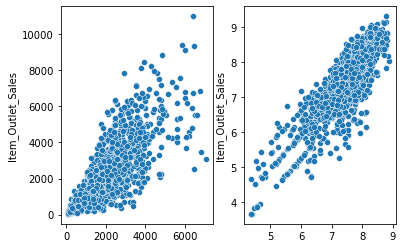

In [17]:
fig,ax =plt.subplots(1,2)
sns.scatterplot(y_pred_inverse,y_test_inverse,ax=ax[0])
sns.scatterplot(y_pred,y_test,ax=ax[1])
plt.show()

## XGboost Regression

In [18]:
params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

xgbr = ensemble.GradientBoostingRegressor(**params)

Model_xgboost = Pipeline([('preprocesamiento',prepoc),
                       ('Boosting_Reg',xgbr)])


Model_xgboost.fit(X_train,y_train)

y_pred = Model_xgboost.predict(X_test)
y_pred_inverse = np.expm1(y_pred)
y_test_inverse = np.expm1(y_test)

print('R2 del modelo XGBoost PERO, del valor log(y+1)',Model_xgboost.score(X_test,y_test))
print('RMSE del modelo XGBoost con la escala real de y',np.sqrt(mean_squared_error(y_test_inverse,y_pred_inverse)))

R2 del modelo XGBoost PERO, del valor log(y+1) 0.7199773985155755
RMSE del modelo XGBoost con la escala real de y 1125.0716411101128


D:\Users\FRLUENGA\.conda\envs\MAPIE_Calibration\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Users\FRLUENGA\.conda\envs\MAPIE_Calibration\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


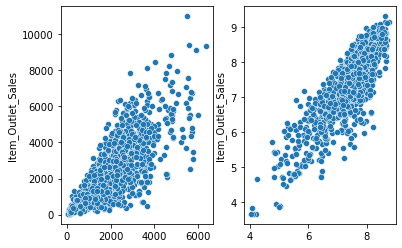

In [19]:
fig,ax =plt.subplots(1,2)
sns.scatterplot(y_pred_inverse,y_test_inverse,ax=ax[0])
sns.scatterplot(y_pred,y_test,ax=ax[1])
plt.show()

## GridSearchCV: Configuración de Hiperparametros

In [20]:
grid_params = {
    "gb__n_estimators": [250,500],
    "gb__max_depth": [10,15,20],
    "gb__loss": ["squared_error",'absolute_error','huber'],
}

params={'min_samples_split':5,
        'learning_rate':0.1}

xgbr = ensemble.GradientBoostingRegressor(**params)

Model_xgboost = Pipeline([('preprocess',prepoc),
                       ('gb',xgbr)])

gs = GridSearchCV(Model_xgboost, 
                  param_grid=grid_params,
                  scoring='neg_mean_squared_error', 
                  n_jobs=2,
                  cv=2, return_train_score=True)

In [29]:
# gs.fit(X_train,y_train)
## por limitaciones computacionales y tiempo no pude correr el modelo

## Calibración: MAPIE intervalos de confianza

In [21]:
X_train_Cal, X_test, y_train_cal, t_test = train_test_split(X,y,test_size=0.2,random_state=42)

X_train, X_cal, y_train, y_cal = train_test_split(X_train_Cal, y_train_cal, test_size=0.5, random_state=42)

In [22]:
## Otra forma de volver Dummys y normalizar a log(x+1) TRAIN
X_train = pd.get_dummies(X_train, columns=vars_catg)
# X_cal.drop(vars_catg,axis=1,inplace=True) no es necesario
X_train[vars_num] = X_train[vars_num].apply(lambda x: np.log1p(x))

## Otra forma de volver Dummys y normalizar a log(x+1) CAL
X_cal = pd.get_dummies(X_cal, columns=vars_catg)
X_cal[vars_num] = X_cal[vars_num].apply(lambda x: np.log1p(x))

## Otra forma de volver Dummys y normalizar a log(x+1) TEST
X_test = pd.get_dummies(X_test, columns=vars_catg)
X_test[vars_num] = X_test[vars_num].apply(lambda x: np.log1p(x))

In [23]:
print('TRAIN: ')
print(X_train.shape)
print(y_train.shape)
print('CALIBRATION: ')
print(X_cal.shape)
print(y_cal.shape)
print('TEST: ')
print(X_test.shape)
print(y_test.shape)

TRAIN: 
(2445, 50)
(2445,)
CALIBRATION: 
(2445, 50)
(2445,)
TEST: 
(1223, 50)
(1223,)


In [24]:
Model_lineal_cal = LinearRegression()
Model_lineal_cal.fit(X_train,y_train)
print(Model_lineal_cal.score(X_test,y_test))

0.7180136416600555


In [25]:
mapie = MapieRegressor(estimator=Model_lineal_cal,cv='prefit').fit(X_cal,y_cal)

D:\Users\FRLUENGA\.conda\envs\MAPIE_Calibration\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [27]:
# Obtener los intervalos de confianza a un nivel de significancia del 0.05
# solo para 5 observaciones
y_test_pred_interval = pd.DataFrame(mapie.predict(X_test,alpha=0.05)[1].reshape(-1,2),index=X_test.index,columns=['Left','Right']
                                   )
y_test_pred_interval.iloc[:5,:]

D:\Users\FRLUENGA\.conda\envs\MAPIE_Calibration\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Left,Right
5680,6.731914,8.762227
446,3.642558,5.672871
4053,6.294902,8.325215
8194,4.772441,6.802754
6185,7.120586,9.150899


* Con el 5% para el nivel de significancia, estamos indicando que estamos dispuestos a obtener que no mas del 5 porciendo de las predicciones caigan por fuera del intervalo de confianza.

#### ¿Cómo comprobamos esto?

In [29]:
out_of_interval = (
        (y_test<y_test_pred_interval['Left']) |
        (y_test>y_test_pred_interval['Right'])
).sum() / len(y_test)
out_of_interval

0.04251839738348324

### Ejemplo Detallado Con RandomForestRegressor

In [33]:
params = {
    'n_estimators' : [50,100,150,200],
    'criterion' : ['squared_error', 'absolute_error', 'poisson']
}
model = RandomForestRegressor(bootstrap=True)

In [34]:
grid_rf = GridSearchCV(model,param_grid=params,
                      scoring='neg_mean_squared_error',
                      n_jobs=2,
                      cv=3,
                      return_train_score=True)

In [35]:
grid_rf.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=2,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [36]:
print(grid_rf.best_params_)

{'criterion': 'absolute_error', 'n_estimators': 200}


In [38]:
model = RandomForestRegressor(n_estimators = 200, criterion = 'absolute_error', bootstrap=True)

In [39]:
model.fit(X_train,y_train)

RandomForestRegressor(criterion='absolute_error', n_estimators=200)

In [67]:
# predict MAE of calibration
y_cal_pred = model.predict(X_cal)

# real scale
y_cal_error = np.abs(np.expm1(y_cal) - np.expm1(y_cal_pred))
# alpha level 0.05
quantile = y_cal_error.quantile(q=0.95,interpolation='higher')
# predict test
y_test_pred = model.predict(X_test)
# confidence interval
y_test_int_left = np.expm1(y_test_pred) - quantile
y_test_int_right = np.expm1(y_test_pred) + quantile

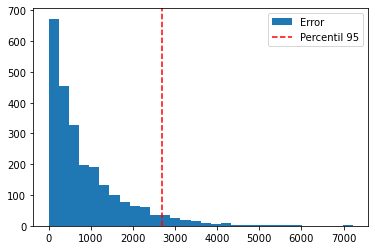

In [65]:
fig,ax = plt.subplots()
ax.hist(y_cal_error,bins=30,label='Error')
ax.axvline(quantile,color='red',linestyle='--',label='Percentil 95')
ax.legend()
plt.show()

In [66]:
quantile

2700.55935371269

* Lo que significa que el error del modelo de randomforest es mayor a 2700 en el 5% de los casos.
* Los intervalos de confianza definen el rango en el cual debe registrar el valor de la predicción

In [70]:
y_pred_scale = np.expm1(y_test_pred)
y_test_scale = np.expm1(y_test)
print('RMSE para el Randomforest en escala real',np.sqrt(mean_squared_error(y_pred_scale,y_test_scale)))

RMSE para el Randomforest en escala real 1171.3076079036487
